In [36]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from collections import Counter
import tensorflow as tf
from tensorflow import reduce_sum
from keras import layers, models
from keras.models import Model
from keras.layers import (Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, 
                          UpSampling2D, UpSampling3D, Add, BatchNormalization, Input, Activation, Lambda, Concatenate)
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy, sparse_categorical_crossentropy
from keras.applications import DenseNet121
from keras.models import load_model
import pickle

In [37]:
IMG_SIZE = (256, 256)
ROOT_DIR = "datasets/dataset_split"

In [38]:
# Mengambil nama-nama kelas dari direktori
CLASS_NAMES = ['ablation', 'breakdown', 'fracture', 'groove']

# Membuat mapping dari nama kelas ke indeks
CLASS_TO_INDEX = {name: index for index, name in enumerate(CLASS_NAMES)}

# Menghitung jumlah kelas
NUM_CLASSES = len(CLASS_NAMES) + 1

# Load Data Test

In [39]:
def load_image_mask(image_path, mask_path):
    # Gambar dibaca, di-decode, dan di-resize (format PNG).
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # Standardisasi ke rentang 0.0 - 1.0
    img = tf.cast(img, tf.float32) / 255.0

    # Mask dibaca, di-decode, dan di-resize.
    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, IMG_SIZE, method='nearest')
    msk = tf.cast(msk, tf.int32)  # pastikan integer
    
    # Ubah mask ke one-hot sesuai NUM_CLASSES
    msk = tf.squeeze(msk, axis=-1)
    msk = tf.one_hot(msk, depth=NUM_CLASSES)
    return img, msk

In [40]:
def get_dataset(split_dir, batch_size=8, shuffle=True):
    img_dir = os.path.join(split_dir, 'images')
    mask_dir = os.path.join(split_dir, 'masks')
    img_files = set([
        f for f in os.listdir(img_dir)
        if not (f.startswith('.') or f.startswith('._')) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    mask_files = set([
        f for f in os.listdir(mask_dir)
        if not (f.startswith('.') or f.startswith('._')) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    common_files = sorted(list(img_files & mask_files))
    img_paths = [os.path.join(img_dir, f) for f in common_files]
    mask_paths = [os.path.join(mask_dir, f) for f in common_files]
    print(f"Jumlah data di {split_dir}: {len(img_paths)}")
    assert len(img_paths) == len(mask_paths), f"Jumlah gambar ({len(img_paths)}) dan mask ({len(mask_paths)}) tidak sama!"
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(100, seed=42)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [41]:
test_ds = get_dataset(f'{ROOT_DIR}/test', batch_size=4, shuffle=False)

Jumlah data di datasets/dataset_split/test: 227


# Metrix

In [42]:
def multi_class_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    matches = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    return tf.reduce_mean(matches)

In [43]:
# Precision, recall, dan f1-score
def multi_class_precision(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    predicted_positives = tf.cast(tf.size(y_pred), tf.float32)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def multi_class_recall(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    true_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    actual_positives = tf.cast(tf.size(y_true), tf.float32)
    return true_positives / (actual_positives + tf.keras.backend.epsilon())


def multi_class_f1(y_true, y_pred):
    precision = multi_class_precision(y_true, y_pred)
    recall = multi_class_recall(y_true, y_pred)
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())


In [44]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)

    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

In [45]:
def iou_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)


# Load Model

In [46]:
# Pastikan custom_objects berisi fungsi metrik yang digunakan
custom_objects = {
    'dice_coef': dice_coef,
    'iou_score': iou_score,
    'multi_class_accuracy': multi_class_accuracy,
    'multi_class_precision': multi_class_precision,
    'multi_class_recall': multi_class_recall,
    'multi_class_f1': multi_class_f1
}

In [47]:
class DummyHistory:
    def __init__(self, history):
        self.history = history

In [48]:
with open('model/history_unet.pkl', 'rb') as f:
    history_unet_dict = pickle.load(f)
history_unet = DummyHistory(history_unet_dict)

with open('model/history_rec_unet.pkl', 'rb') as f:
    history_rec_unet_dict = pickle.load(f)
history_rec_unet = DummyHistory(history_rec_unet_dict)

In [49]:
model_unet = load_model('model/unet.keras', custom_objects=custom_objects)
model_rec_unet = load_model('model/recurrent_unet.keras', custom_objects=custom_objects)

TypeError: Could not locate function 'loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'loss', 'registered_name': 'function'}

# Visualisasi Metrix

In [9]:
def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    plt.figure(figsize=(18, 12))
    for i, metric in enumerate(metrics):
        plt.subplot(2, (len(metrics)+1)//2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.title(metric)
    plt.tight_layout()
    plt.show()

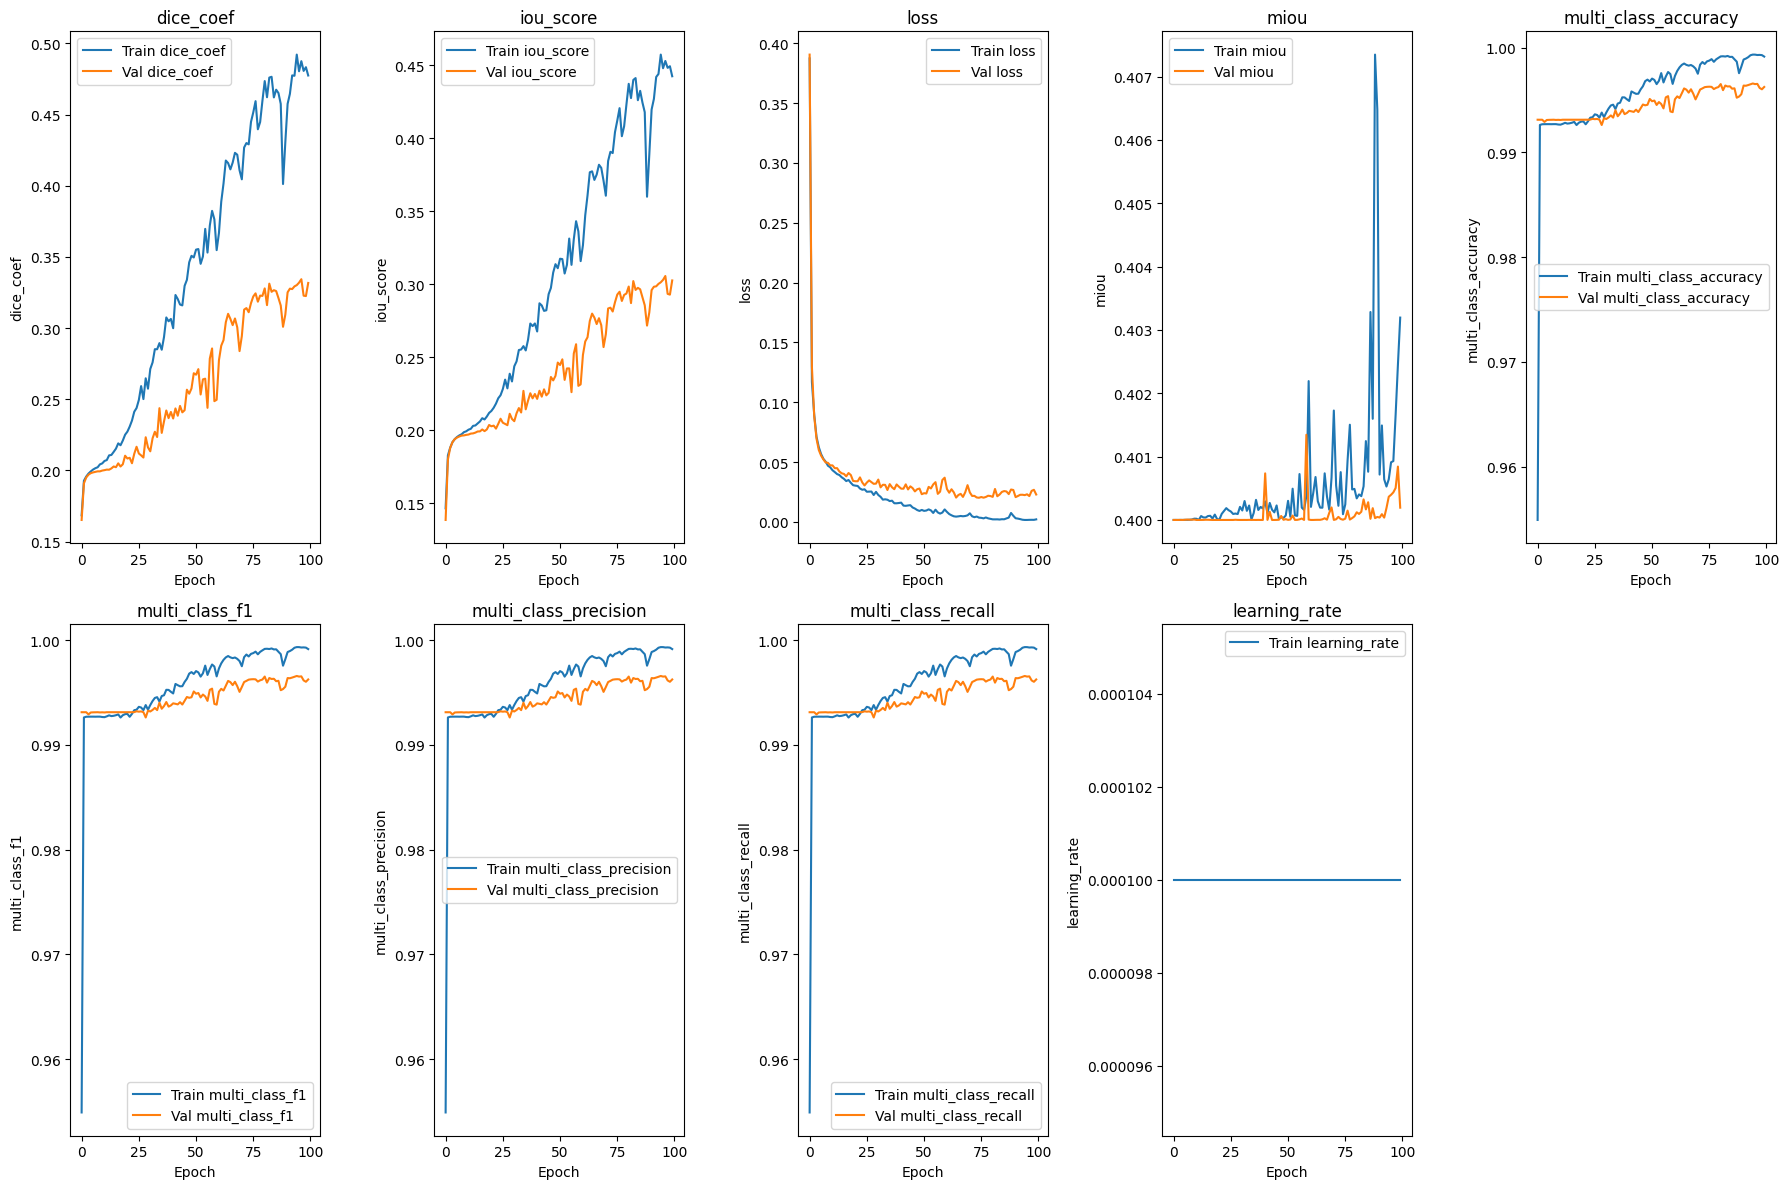

In [15]:
plot_history(history_unet)

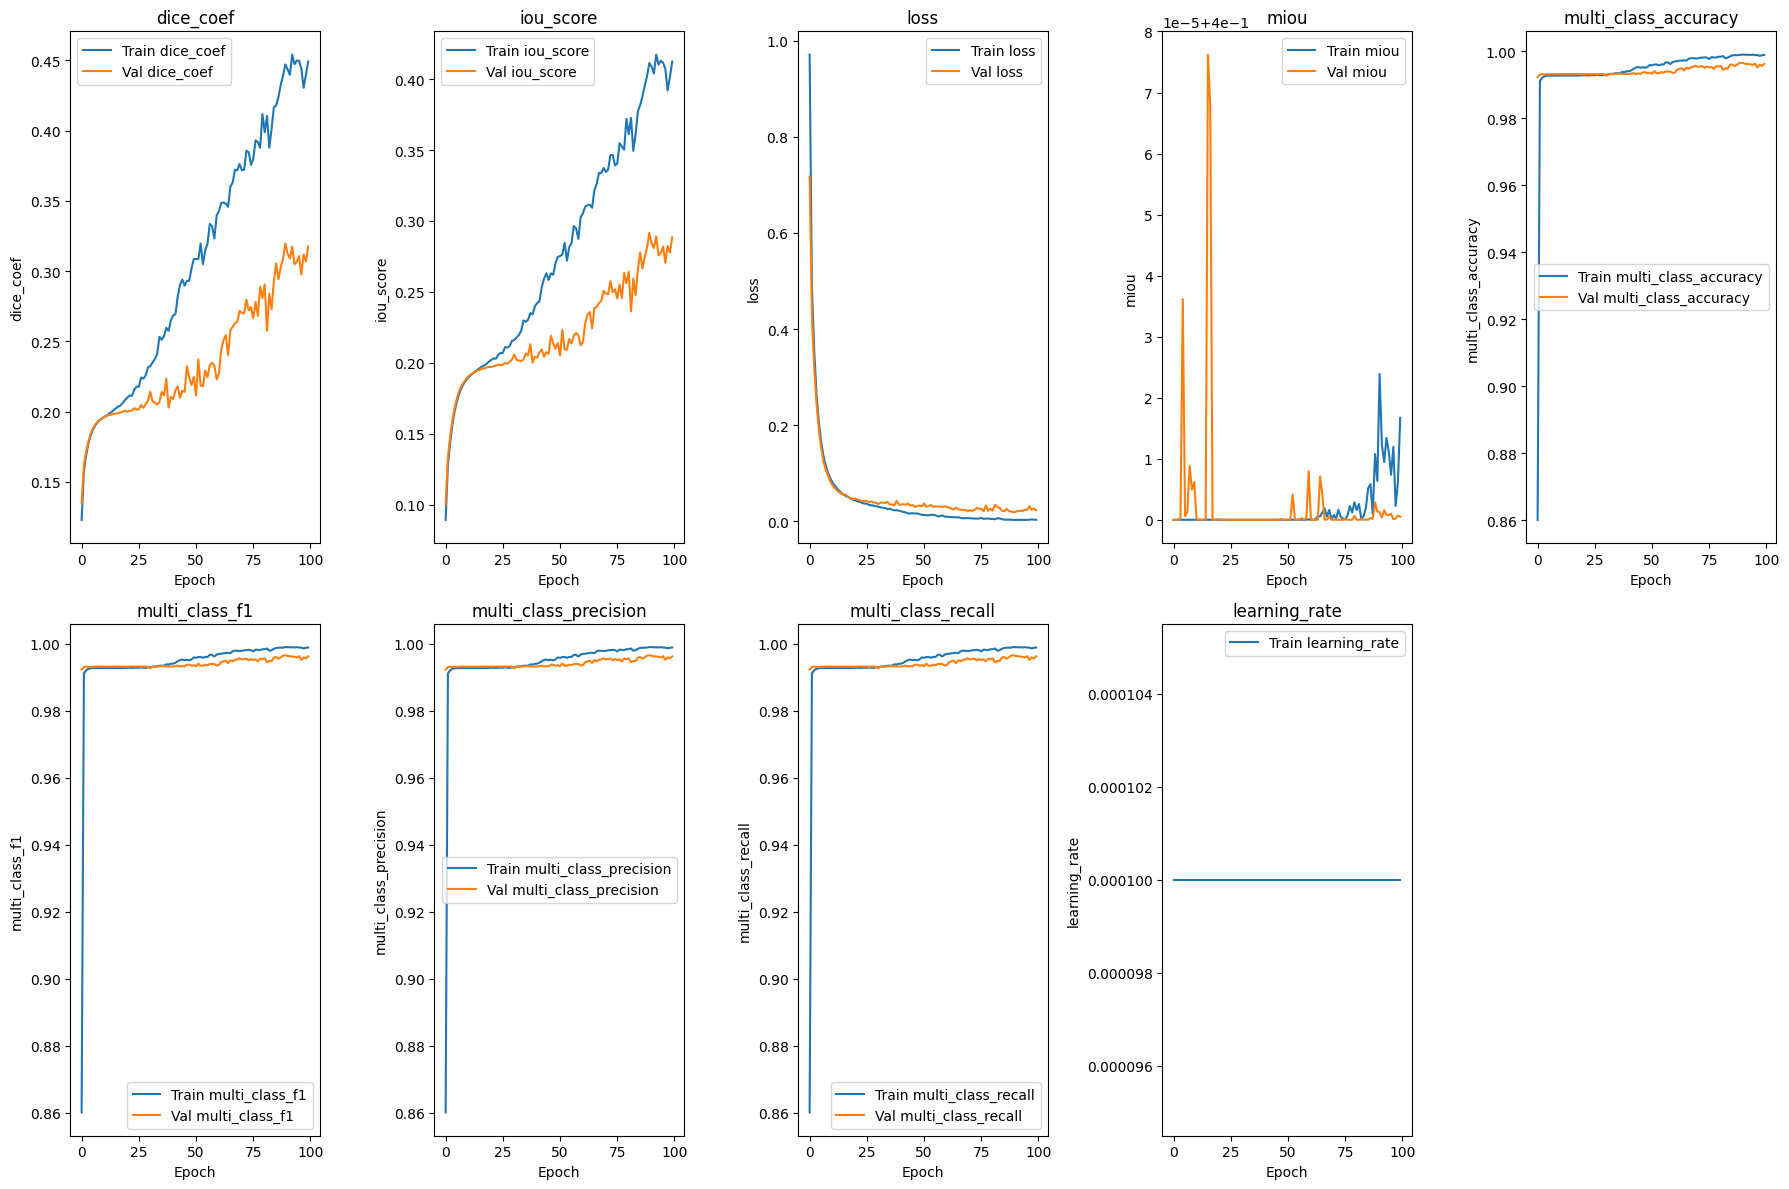

In [16]:
plot_history(history_rec_unet)

# Evaluation Testing

In [ ]:
# Evaluasi model U-Net pada data test
results_unet = model_unet.evaluate(test_ds, verbose=1)
print("\nHasil evaluasi U-Net pada data test:")
for name, value in zip(model_unet.metrics_names, results_unet):
    print(f"{name}: {value:.4f}")

# Evaluasi model Recurrent U-Net pada data test
results_rec_unet = model_rec_unet.evaluate(test_ds, verbose=1)
print("\nHasil evaluasi Recurrent U-Net pada data test:")
for name, value in zip(model_rec_unet.metrics_names, results_rec_unet):
    print(f"{name}: {value:.4f}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2140558813.py, line 10)

In [27]:
# Evaluasi model U-Net pada data test
results_unet = model_unet.evaluate(test_ds, verbose=0)
metrics_unet = dict(zip(model_unet.metrics_names, results_unet))

print("\nHasil evaluasi U-Net pada data test:")
print(f"Accuracy      : {metrics_unet.get('multi_class_accuracy', 0):.4f}")
print(f"F1-score      : {metrics_unet.get('multi_class_f1', 0):.4f}")
print(f"Precision     : {metrics_unet.get('multi_class_precision', 0):.4f}")
print(f"Recall        : {metrics_unet.get('multi_class_recall', 0):.4f}")
print(f"Dice Coef     : {metrics_unet.get('dice_coef', 0):.4f}")
print(f"IoU Score     : {metrics_unet.get('iou_score', 0):.4f}")

# Evaluasi model Recurrent U-Net pada data test
results_rec_unet = model_rec_unet.evaluate(test_ds, verbose=0)
metrics_rec_unet = dict(zip(model_rec_unet.metrics_names, results_rec_unet))

print("\nHasil evaluasi Recurrent U-Net pada data test:")
print(f"Accuracy      : {metrics_rec_unet.get('multi_class_accuracy', 0):.4f}")
print(f"F1-score      : {metrics_rec_unet.get('multi_class_f1', 0):.4f}")
print(f"Precision     : {metrics_rec_unet.get('multi_class_precision', 0):.4f}")
print(f"Recall        : {metrics_rec_unet.get('multi_class_recall', 0):.4f}")
print(f"Dice Coef     : {metrics_rec_unet.get('dice_coef', 0):.4f}")
print(f"IoU Score     : {metrics_rec_unet.get('iou_score', 0):.4f}")


Hasil evaluasi U-Net pada data test:
Accuracy      : 0.0000
F1-score      : 0.0000
Precision     : 0.0000
Recall        : 0.0000
Dice Coef     : 0.0000
IoU Score     : 0.0000

Hasil evaluasi Recurrent U-Net pada data test:
Accuracy      : 0.0000
F1-score      : 0.0000
Precision     : 0.0000
Recall        : 0.0000
Dice Coef     : 0.0000
IoU Score     : 0.0000


In [28]:
for img, mask in test_ds.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)
    print("Mask unique values:", np.unique(mask.numpy()))

Image shape: (4, 256, 256, 3)
Mask shape: (4, 256, 256, 5)
Mask unique values: [0. 1.]


2025-06-12 07:18:51.868186: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
pred = model_unet.predict(img)
print("Pred shape:", pred.shape)
print("Pred unique values:", np.unique(np.argmax(pred, axis=-1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Pred shape: (4, 256, 256, 5)
Pred unique values: [0 1 3]


In [31]:
for img, mask in test_ds.take(1):
    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)
    print("Mask unique values:", np.unique(mask.numpy()))

Image shape: (4, 256, 256, 3)
Mask shape: (4, 256, 256, 5)
Mask unique values: [0. 1.]


2025-06-12 07:20:21.204132: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
pred = model_unet.predict(img)
print("Pred shape:", pred.shape)
print("Pred unique values:", np.unique(np.argmax(pred, axis=-1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Pred shape: (4, 256, 256, 5)
Pred unique values: [0 1 3]


In [33]:
for img, mask in test_ds.take(1):
    y_true = mask.numpy()
    y_pred = model_unet.predict(img)
    acc = np.mean(np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1))
    print("Manual accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Manual accuracy: 0.9947128295898438


In [35]:
for img, mask in test_ds.take(1):
    y_true = mask.numpy()
    y_pred = model_unet.predict(img)
    acc = np.mean(np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1))
    print("Manual accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
Manual accuracy: 0.9947128295898438
